## read data from files netatmo

In [33]:
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

In [34]:
# supprimer d'abord les deux lignes dans le fichier d'export Neatatmo
index_col="Timestamp"
data1=pd.read_csv('data/Netatmo/CapteurAmbiance1_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col)
data2=pd.read_csv('data/Netatmo/CapteurAmbiance2_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col)
data3=pd.read_csv('data/Netatmo/CapteurAmbiance3_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col)
data4=pd.read_csv('data/Netatmo/CapteurAmbiance4_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col )
#Linky=pd.read_csv('data/Netatmo/Enedis_Conso_DemiHeure_20210401-20220228.csv', sep=";", encoding = "ISO-8859-1")


In [35]:
data= pd.concat([data1, data2, data3, data4], axis=0)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94978 entries, 1617228022 to 1646088954
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Timezone : Europe/Paris  94978 non-null  datetime64[ns]
 1   Temperature              94978 non-null  float64       
 2   Humidity                 94978 non-null  int64         
 3   CO2                      94974 non-null  float64       
 4   Noise                    94974 non-null  float64       
 5   Pressure                 94978 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 5.1 MB


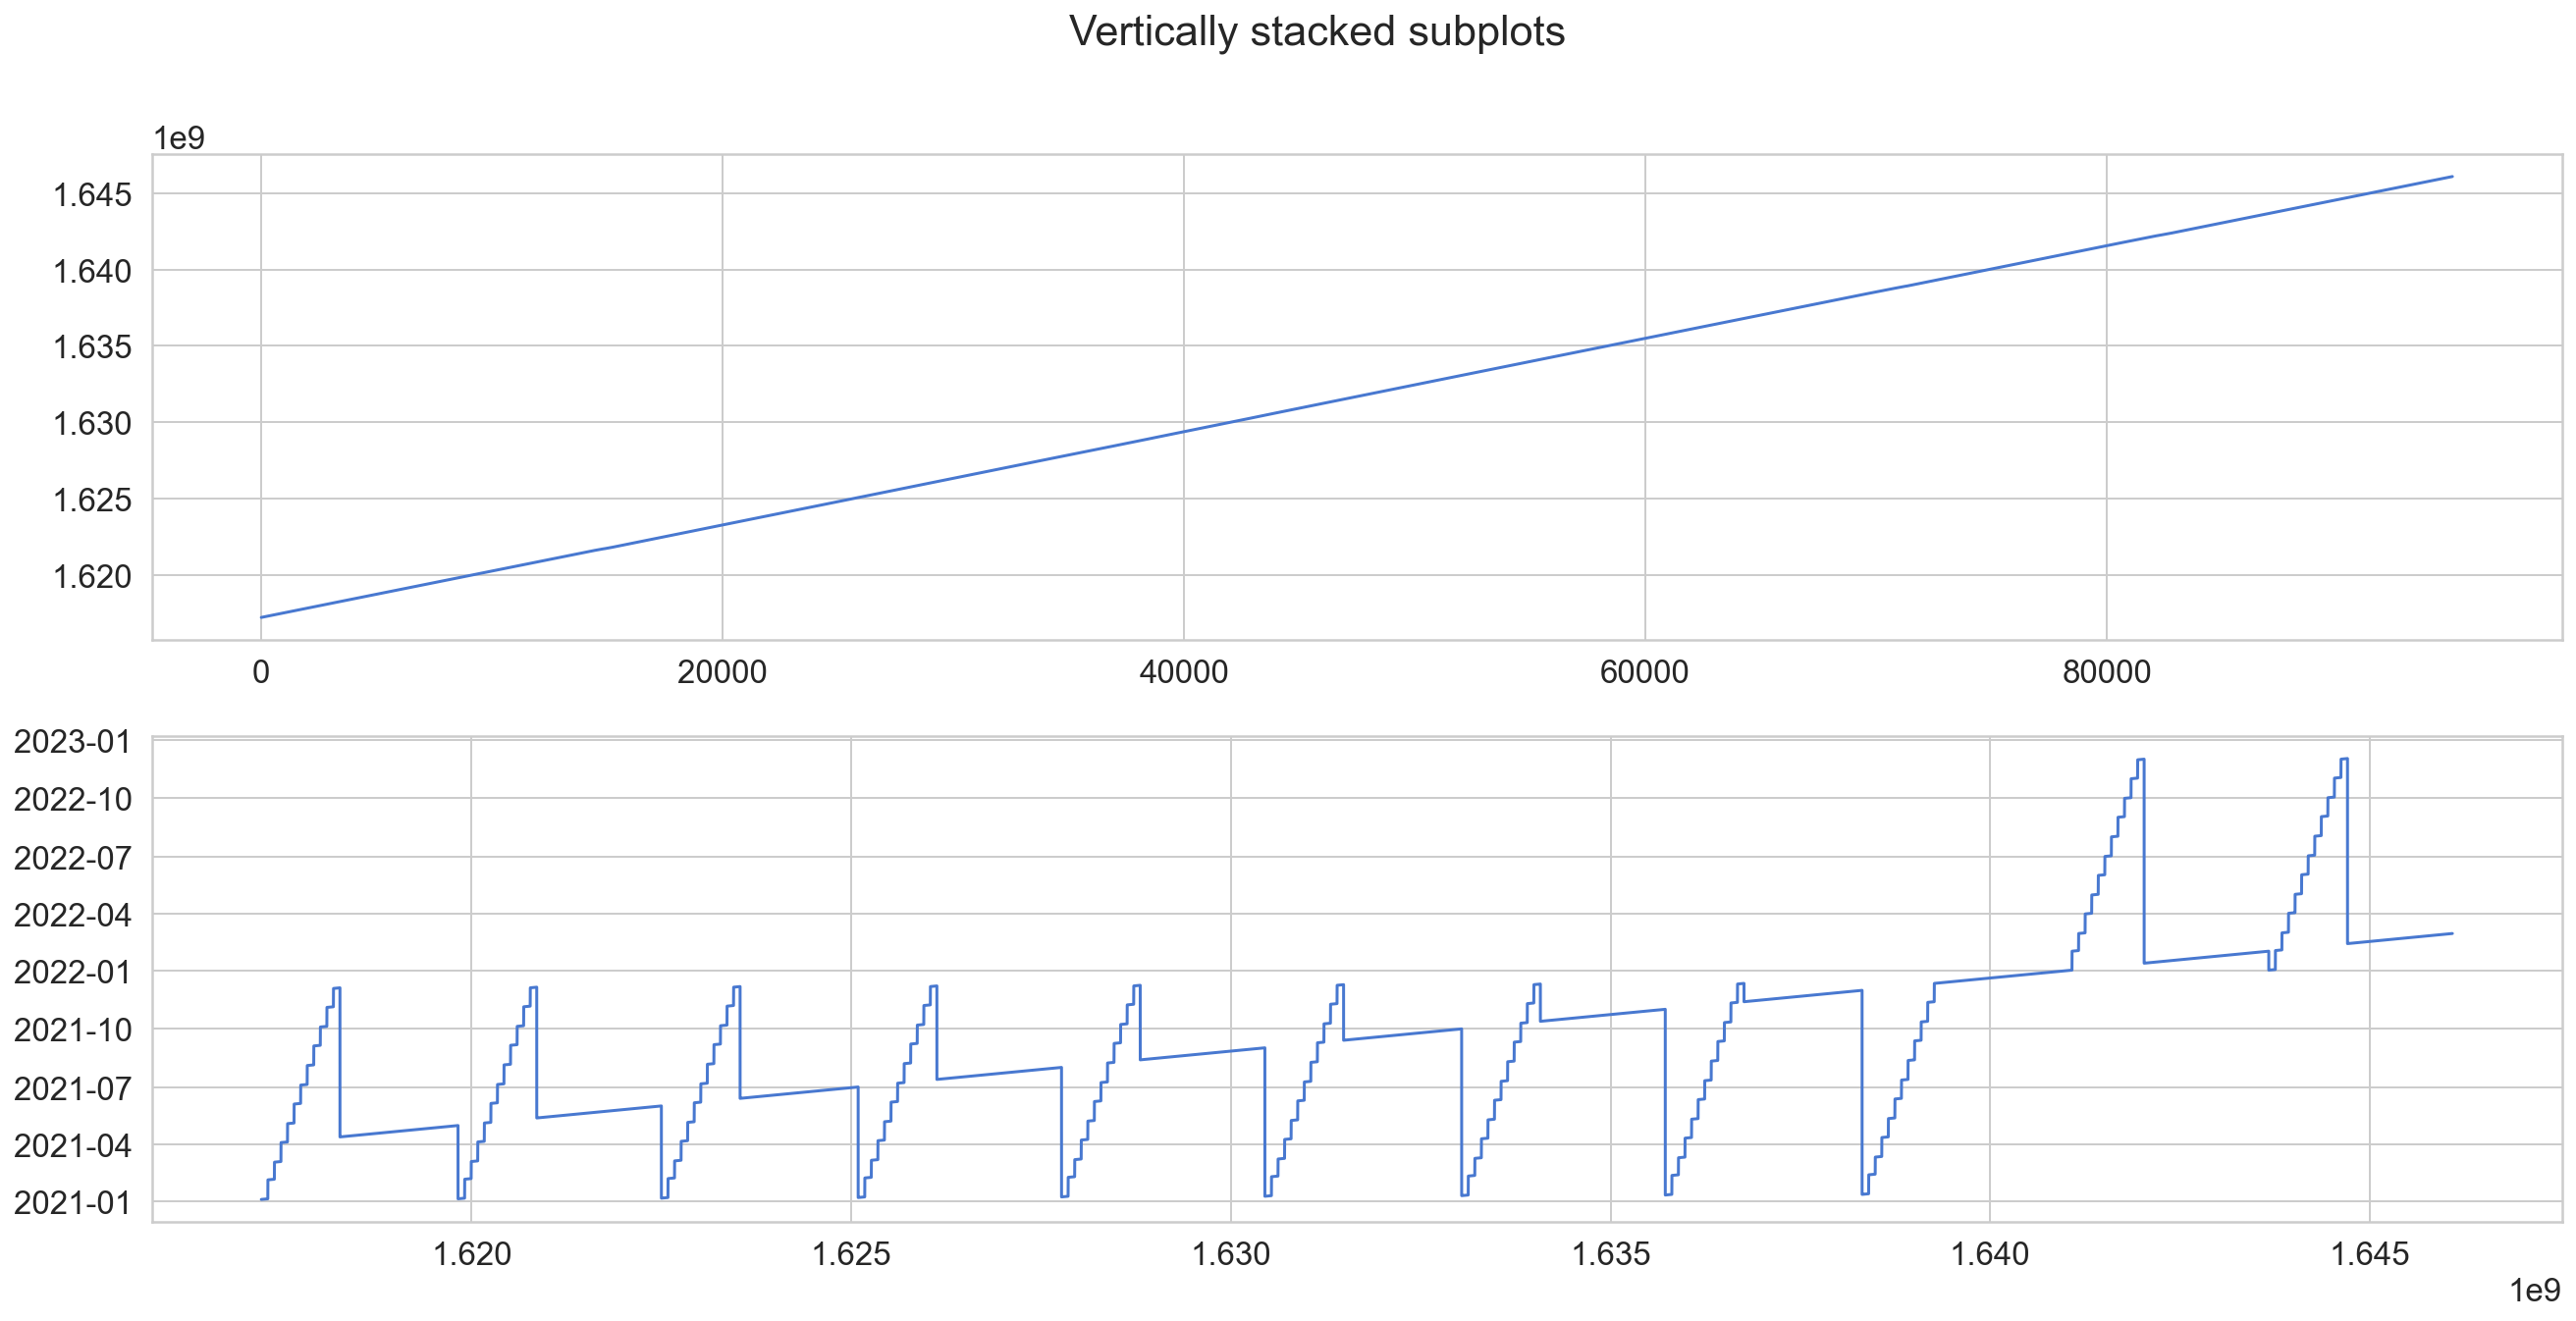

In [37]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(data.index)
axs[1].plot(data["Timezone : Europe/Paris"])

In [464]:
data.to_csv('data.csv') 

## Missing data generation

In [38]:

#!pip install wget 
import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns

In [39]:
# Fix the seed ------------------------------------------------------
np.random.seed(0)

In [40]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [41]:

X = data.copy()
X =X.drop(["Timezone : Europe/Paris"], axis=1)
X = X.values

In [42]:
# Minimal example for generating missing data ------------------------
X_miss_mcar = produce_NA(X, p_miss=0.4, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of newly generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

Percentage of newly generated missing values:  39.967992587757166  %


Percentage of generated missing values:  0.0  %


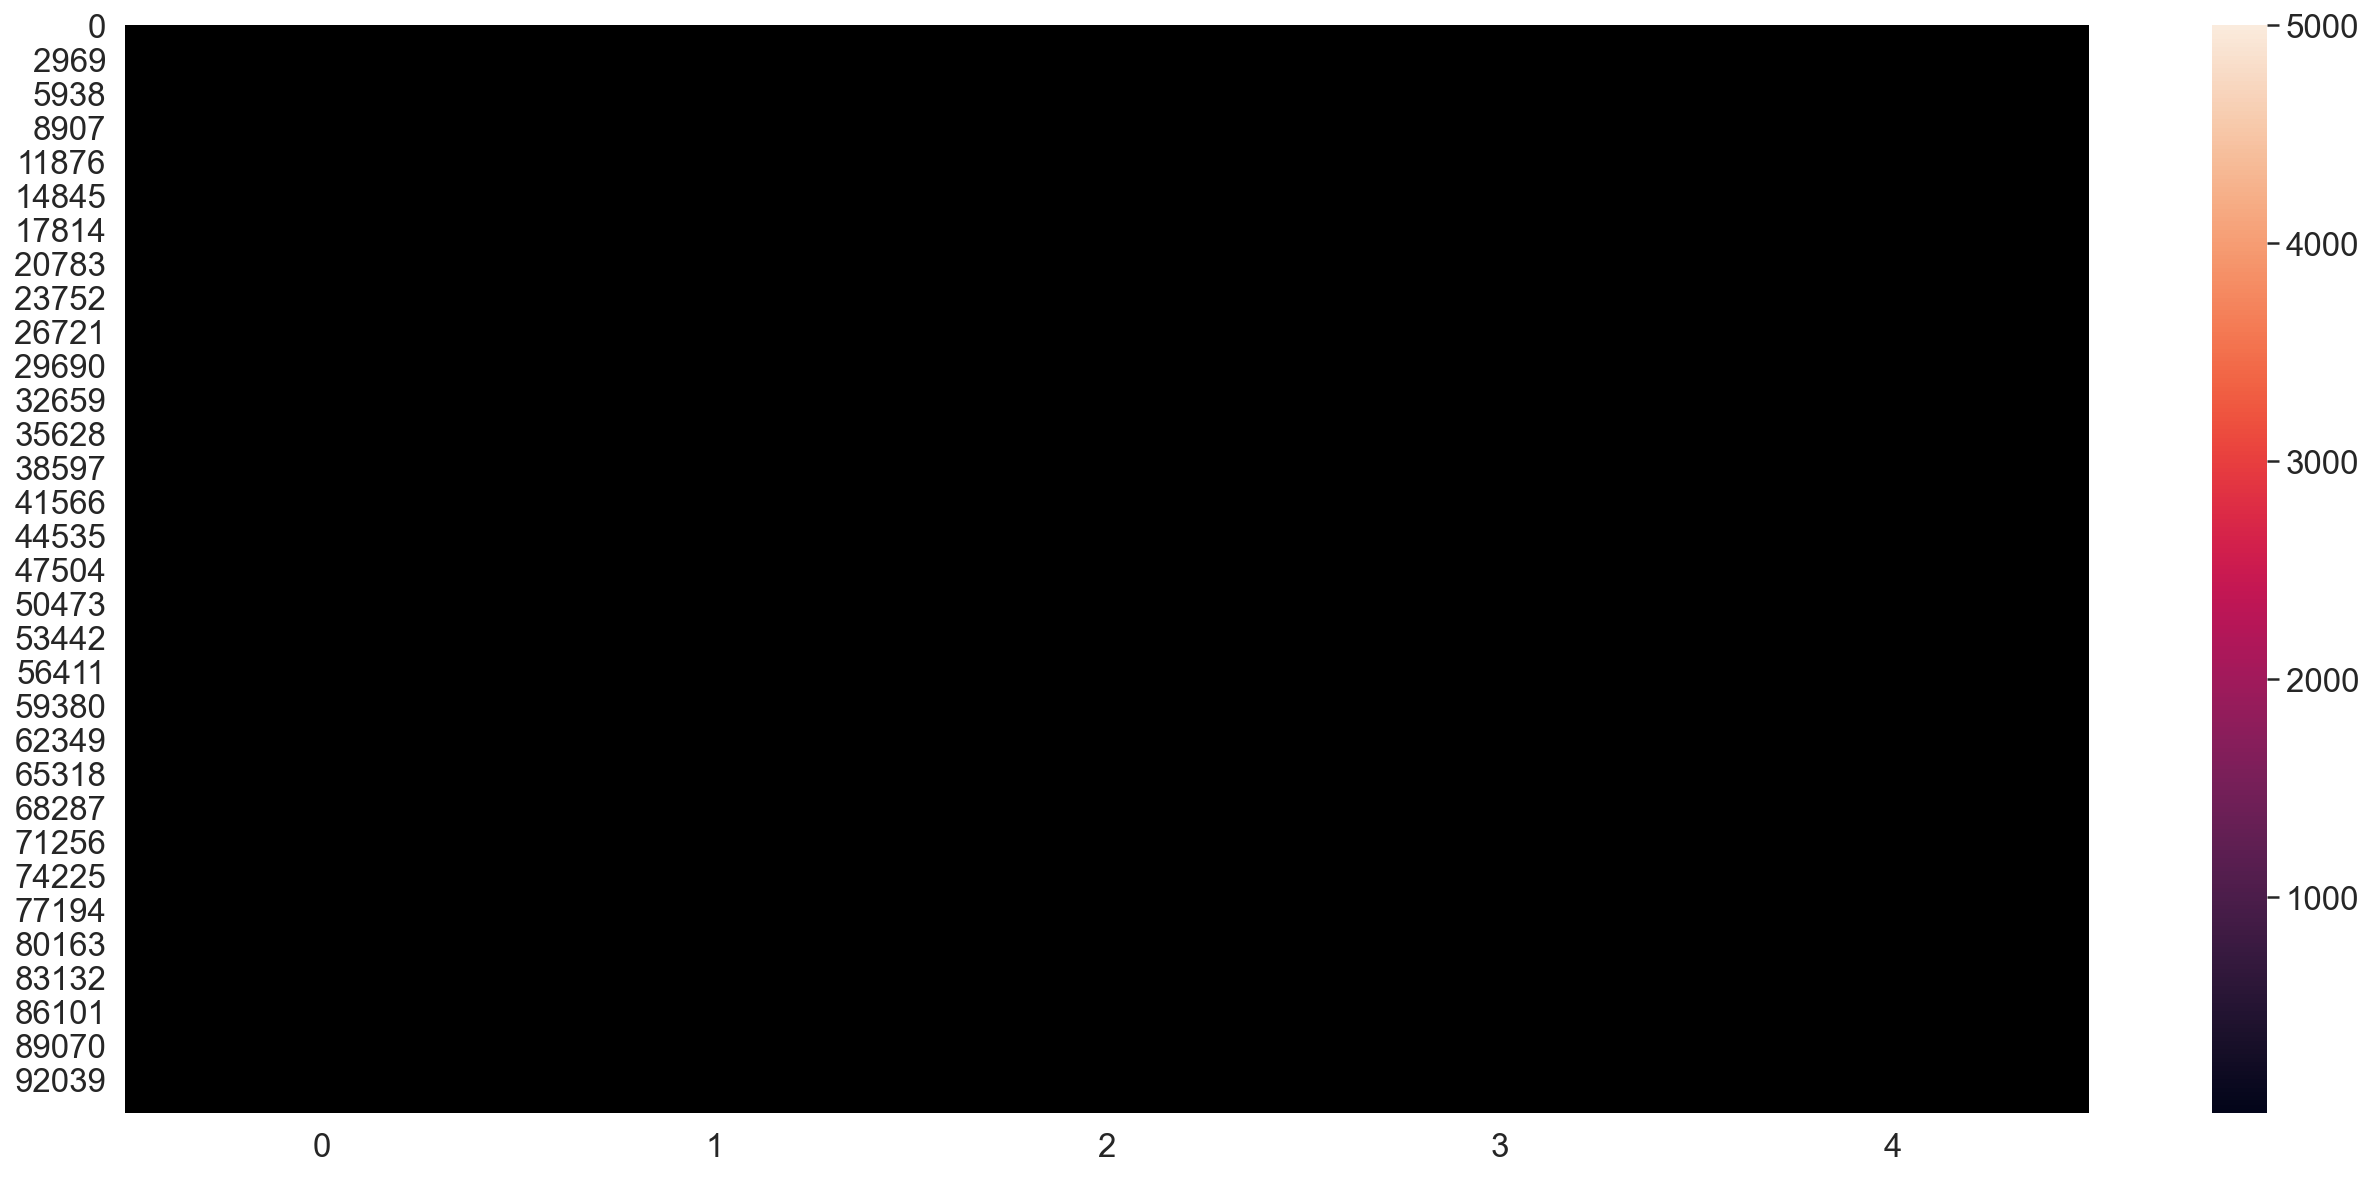

In [84]:
# Sample mar data -----------------------------------------
X_miss_mar = produce_NA(X, p_miss=0.3, mecha="MAR", p_obs=0.04)

X_mar = X_miss_mar['X_incomp']
R_mar = X_miss_mar['mask']

print("Percentage of generated missing values: ", (R_mar.sum()).numpy()/np.prod(R_mar.size())*100, " %")

ax = sns.heatmap(X_mar, mask=R_mar.numpy()==1, linewidths=0.05, linecolor='black')

In [45]:
#df = X_mar
df = X_mcar

In [46]:
df = df.numpy()

In [47]:
df = pd.DataFrame(data=df, columns=['Temperature', 'Humidity', 'CO2', 'Noise','Pressure'])

In [48]:
df['Timestamp']= data.index
df.set_index('Timestamp',inplace = True)


In [49]:
df

Temperature  Humidity    CO2  Noise     Pressure
Timestamp                                                   
1617228022          NaN      58.0    NaN    NaN  1017.200012
1617228324    20.100000       NaN  689.0    NaN          NaN
1617228626    20.100000       NaN  706.0   32.0          NaN
1617228929          NaN      58.0    NaN   32.0  1017.200012
1617229232    20.100000      57.0  689.0    NaN  1017.200012
...                 ...       ...    ...    ...          ...
1646087743    17.000000       NaN    NaN   32.0          NaN
1646088046          NaN      52.0    NaN    NaN          NaN
1646088348          NaN       NaN  764.0    NaN  1024.800049
1646088651    16.799999      52.0  743.0    NaN  1024.699951
1646088954    16.799999       NaN  738.0    NaN          NaN

[94978 rows x 5 columns]

In [50]:
# EDA : describe data quickly by pandas-profiling
## !pip install pandas_profiling   ## si erreur 
from pandas_profiling import ProfileReport
profile=ProfileReport(df, title='Netatmo Air-Quality',html={'style':{'full_width':True}})

In [51]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

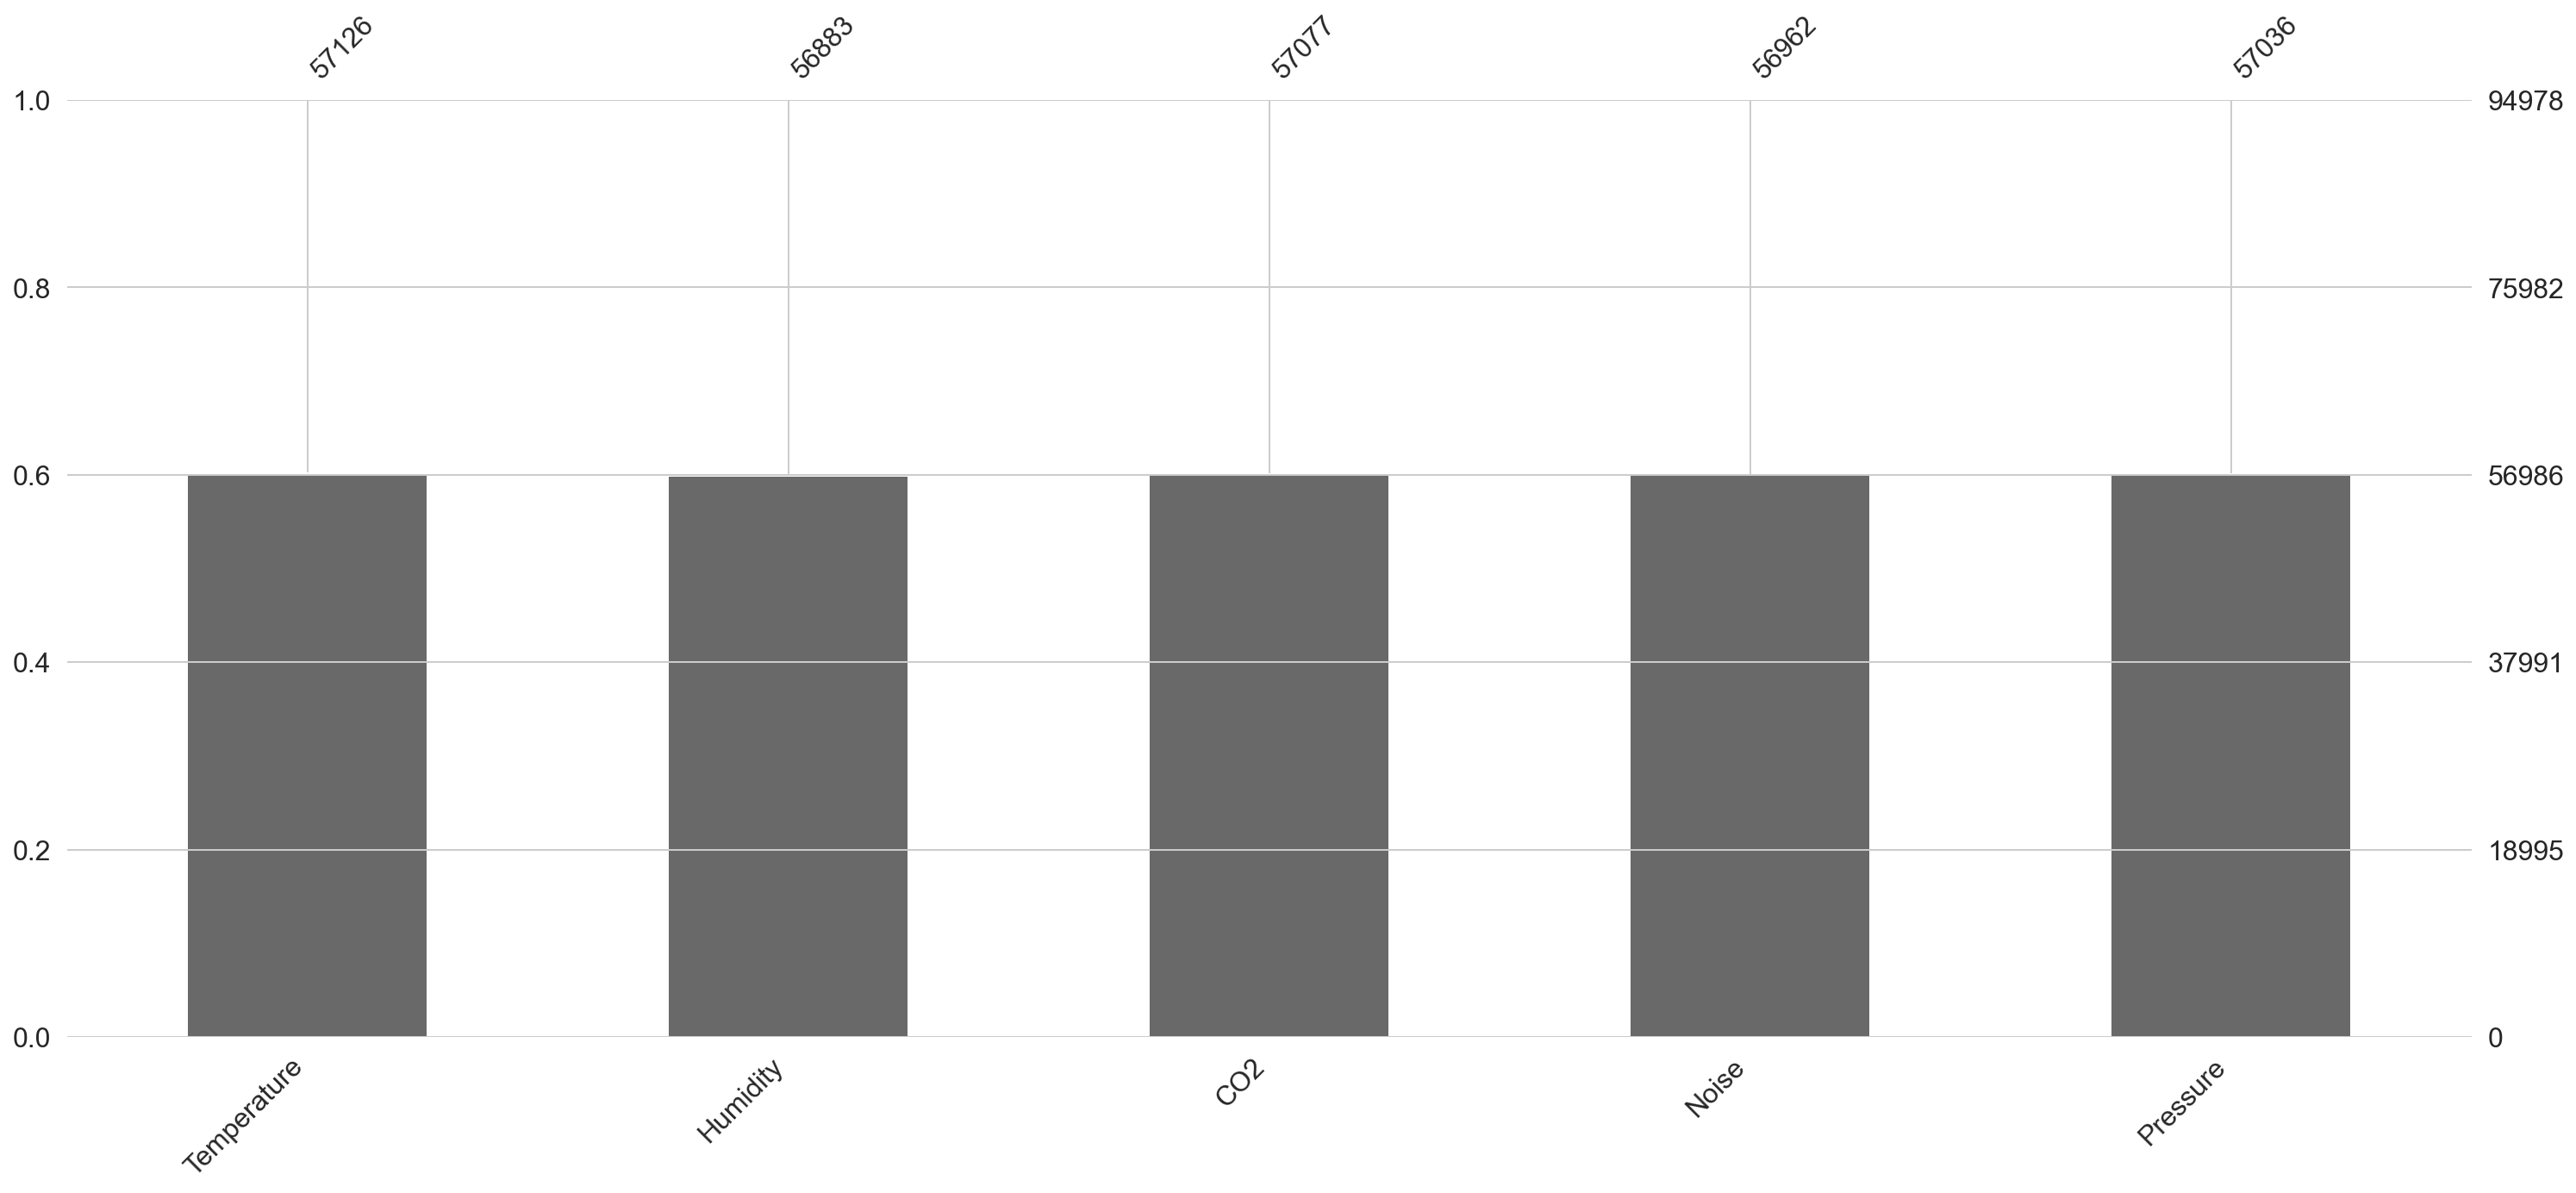

In [52]:
#visualize data 

# Import missingno as msno
import missingno as msno
import matplotlib.pyplot as plt

# Plot amount of missingness
msno.bar(df) # you can see pandas-profilin count part

plt.show()

KeyError: 'Dataframe index must be PeriodIndex or DatetimeIndex.'

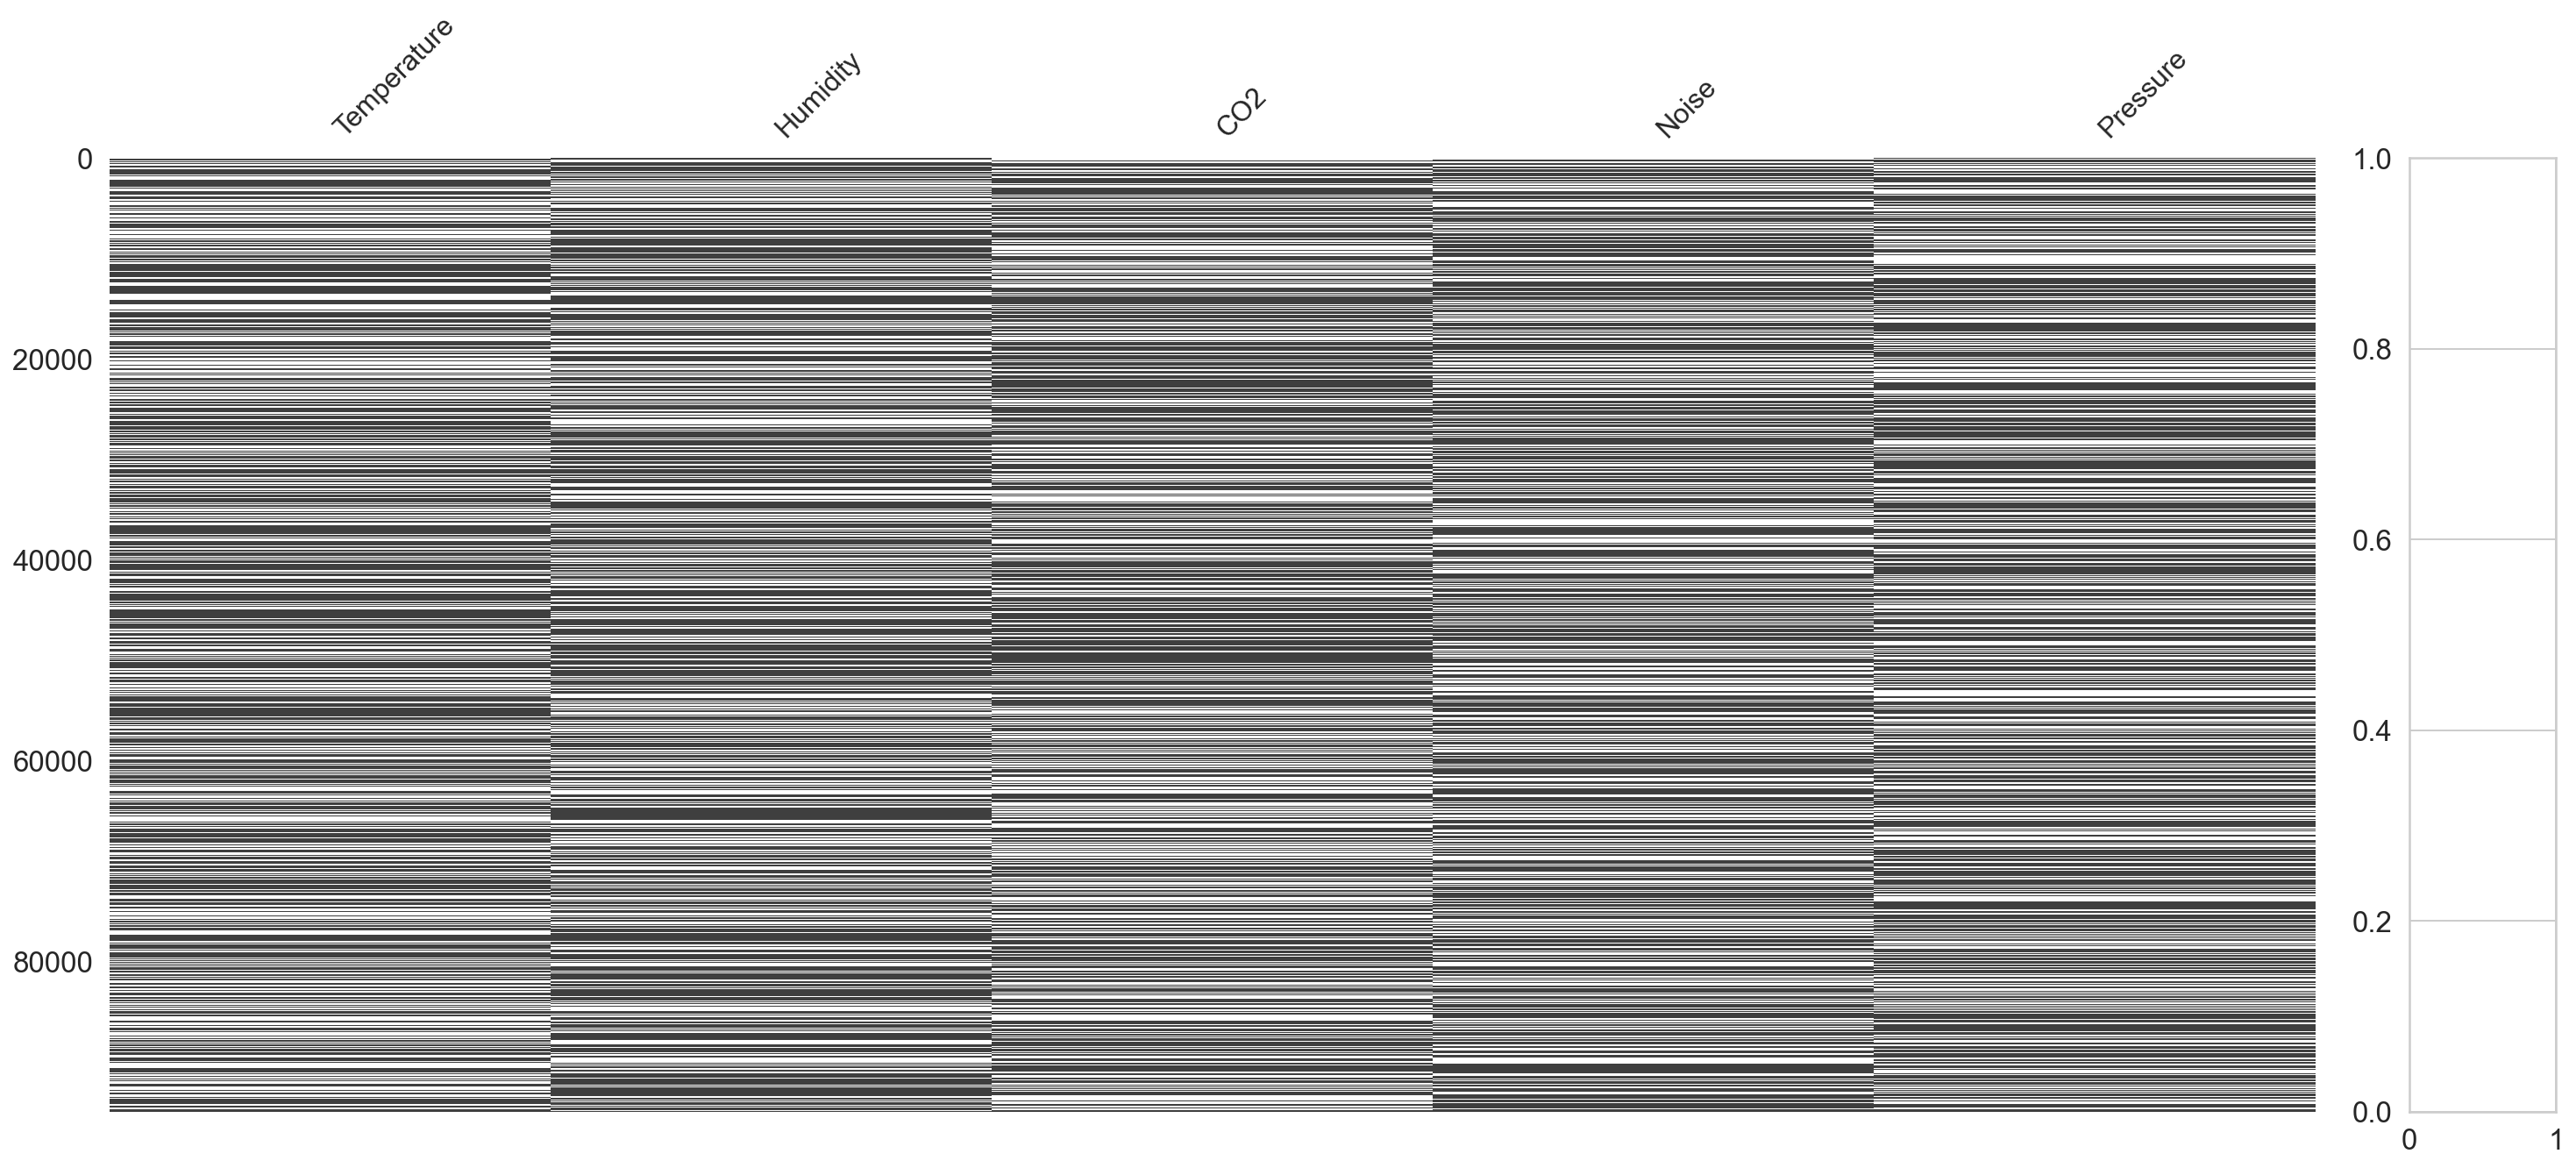

In [53]:
# Plot nullity matrix of airquality with frequency 'M'
msno.matrix(df, freq='M') # this part actually displays the missingness types, also more visible version of pandas-profiling matrix.
plt.show()

## Time Series Imputation Techniques

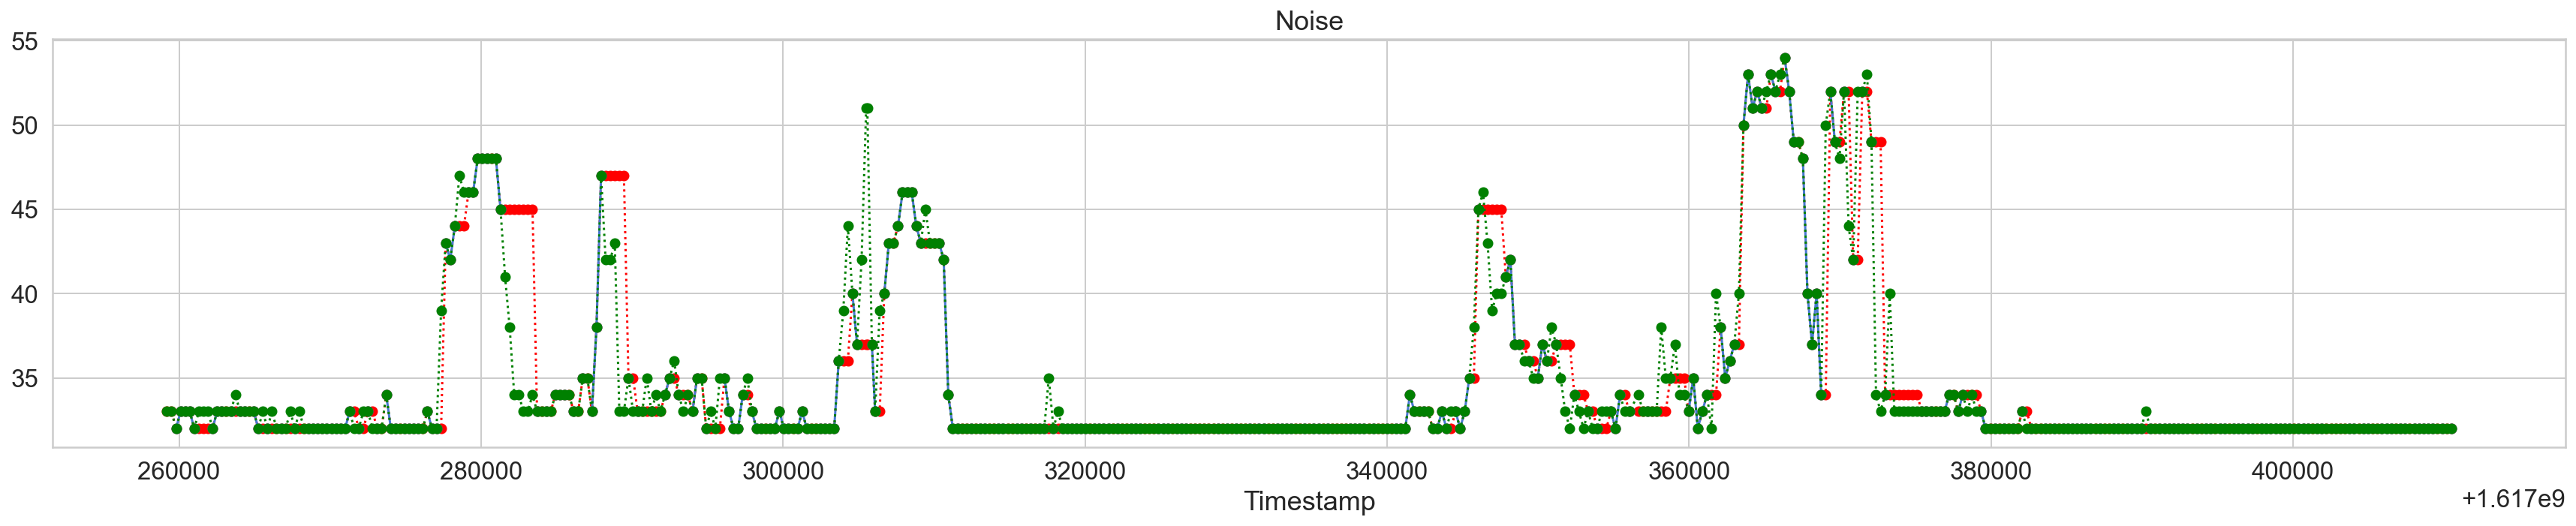

In [103]:
### Forward Fill
# Impute airquality DataFrame with ffill method
columnNam= 'Noise'
a, taille=100,500
ffill_imputed = df.copy(deep=True)

ffill_imputed.fillna(method='ffill',inplace=True)

# Plot the imputed DataFrame ffill_imp in red dotted style 
ffill_imputed[columnNam][a:a + taille].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

# Plot the airquality DataFrame with title
df[columnNam][a:a + taille].plot(title=columnNam, marker='o', figsize=(30, 5))
data[columnNam][a:a + taille].plot(color='green', marker='o', linestyle='dotted', figsize=(30, 5))

plt.show()

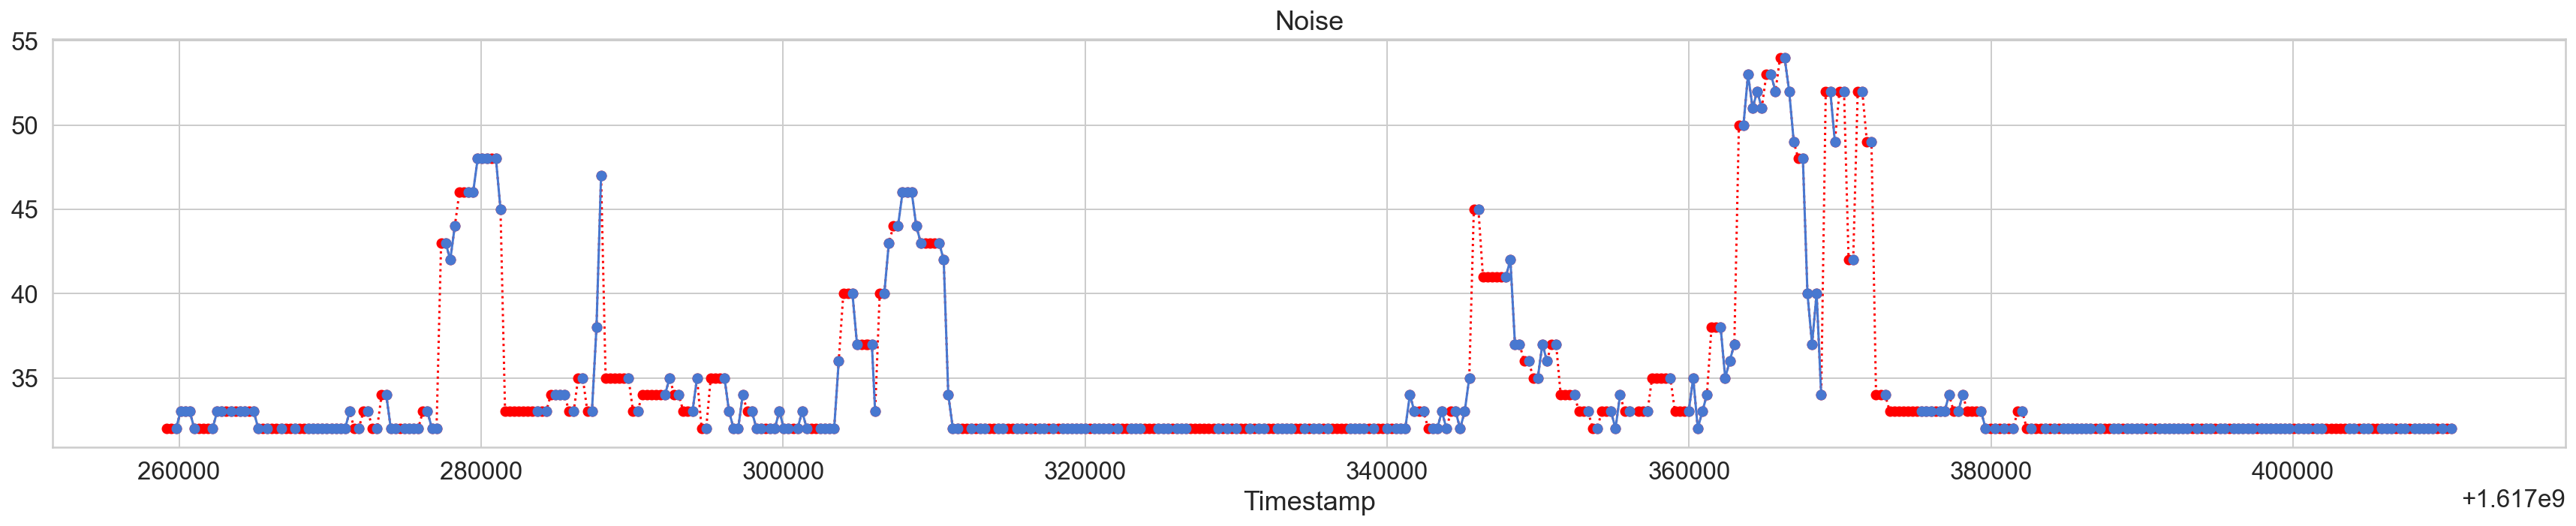

In [104]:
### Back Fill Fill
# Impute airquality DataFrame with bfill method
bfill_imputed = df.copy(deep=True)
bfill_imputed.fillna(method='bfill',inplace=True)

# Plot the imputed DataFrame bfill_imp in red dotted style 
bfill_imputed[columnNam][a:a + taille].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

# Plot the airquality DataFrame with title
df[columnNam][a:a + taille].plot(title=columnNam, marker='o', figsize=(30, 5))
#data[columnNam][a:a + taille].plot(color='green', marker='o', linestyle='dotted', figsize=(30, 5))

plt.show()

<AxesSubplot:xlabel='Timestamp'>

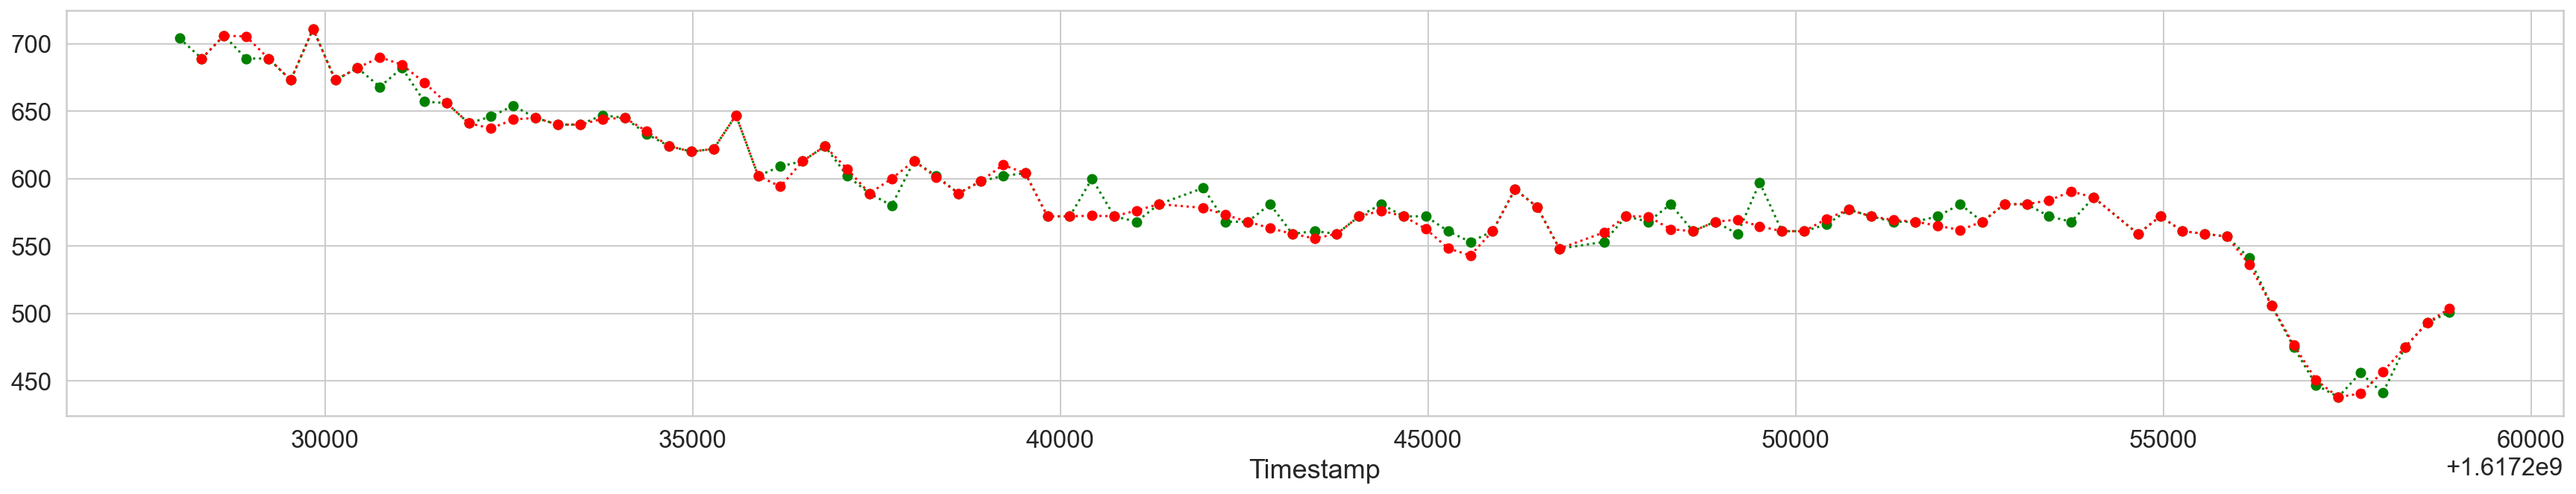

In [99]:
# Interpolate the NaNs quadratically

quadratic_imput=df.copy(deep=True)

quadratic_imput.interpolate(method='quadratic', inplace=True)


#df[columnNam][a:a + taille].plot(title=columnNam, marker='o', figsize=(30, 5))
data[columnNam][a:a + taille].plot(color='green', marker='o', linestyle='dotted', figsize=(30, 5))
quadratic_imput[columnNam][a:a + taille].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))


In [79]:
X_imp = quadratic_imput

<AxesSubplot:title={'center':'Temperature'}, xlabel='Timestamp'>

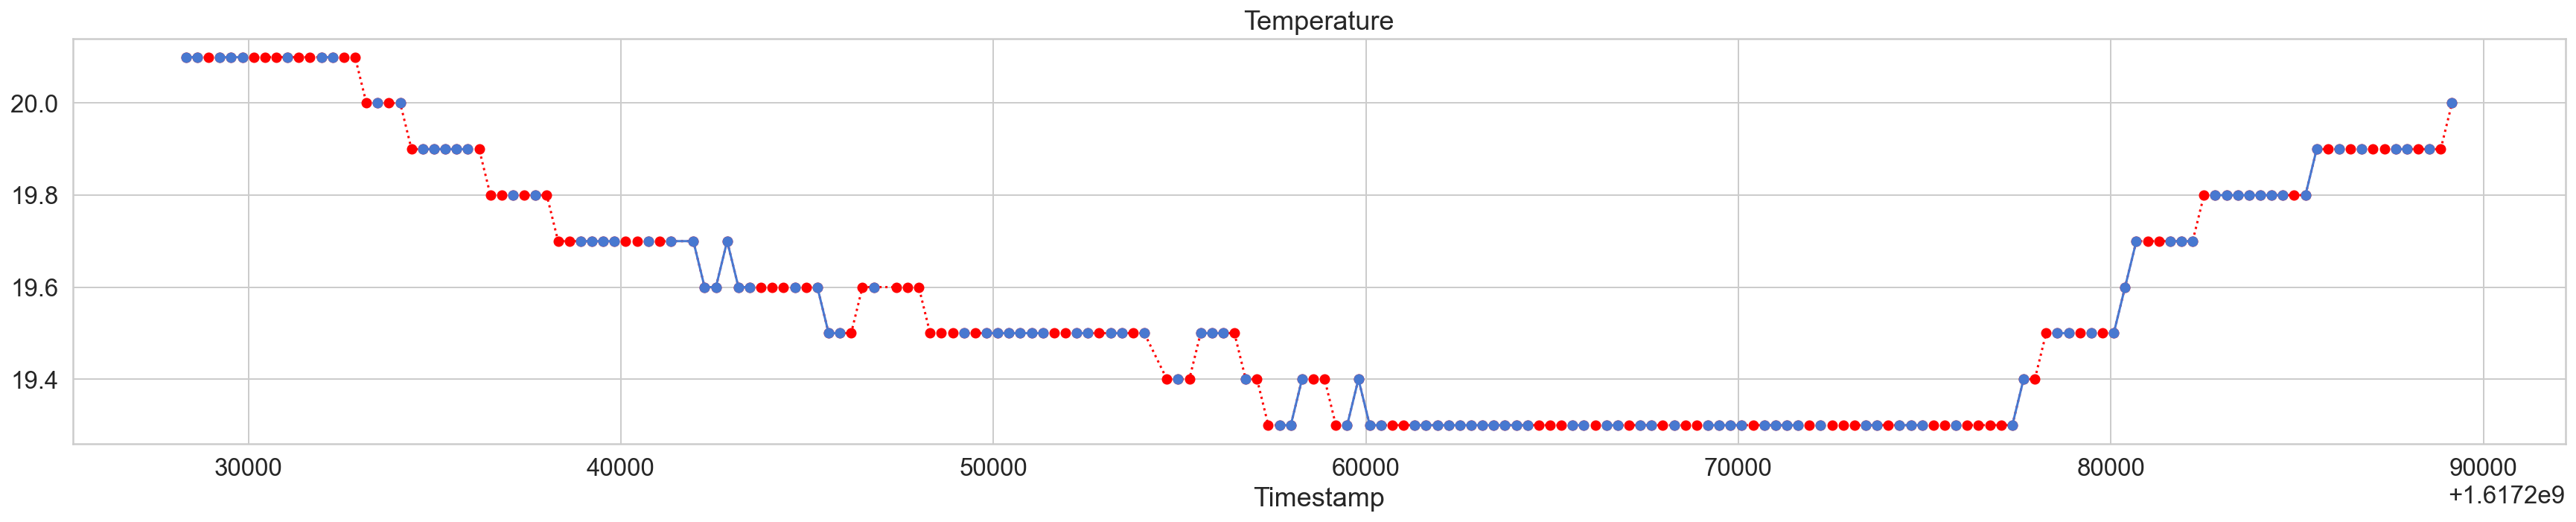

In [80]:
# Interpolate the NaNs by nearest method

nearest_imput=df.copy(deep=True)

nearest_imput.interpolate(method='nearest', inplace=True)

nearest_imput[columnNam][a:a + taille].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

df[columnNam][a:a + taille].plot(title=columnNam, marker='o', figsize=(30, 5))



<AxesSubplot:title={'center':'Temperature'}, xlabel='Timestamp'>

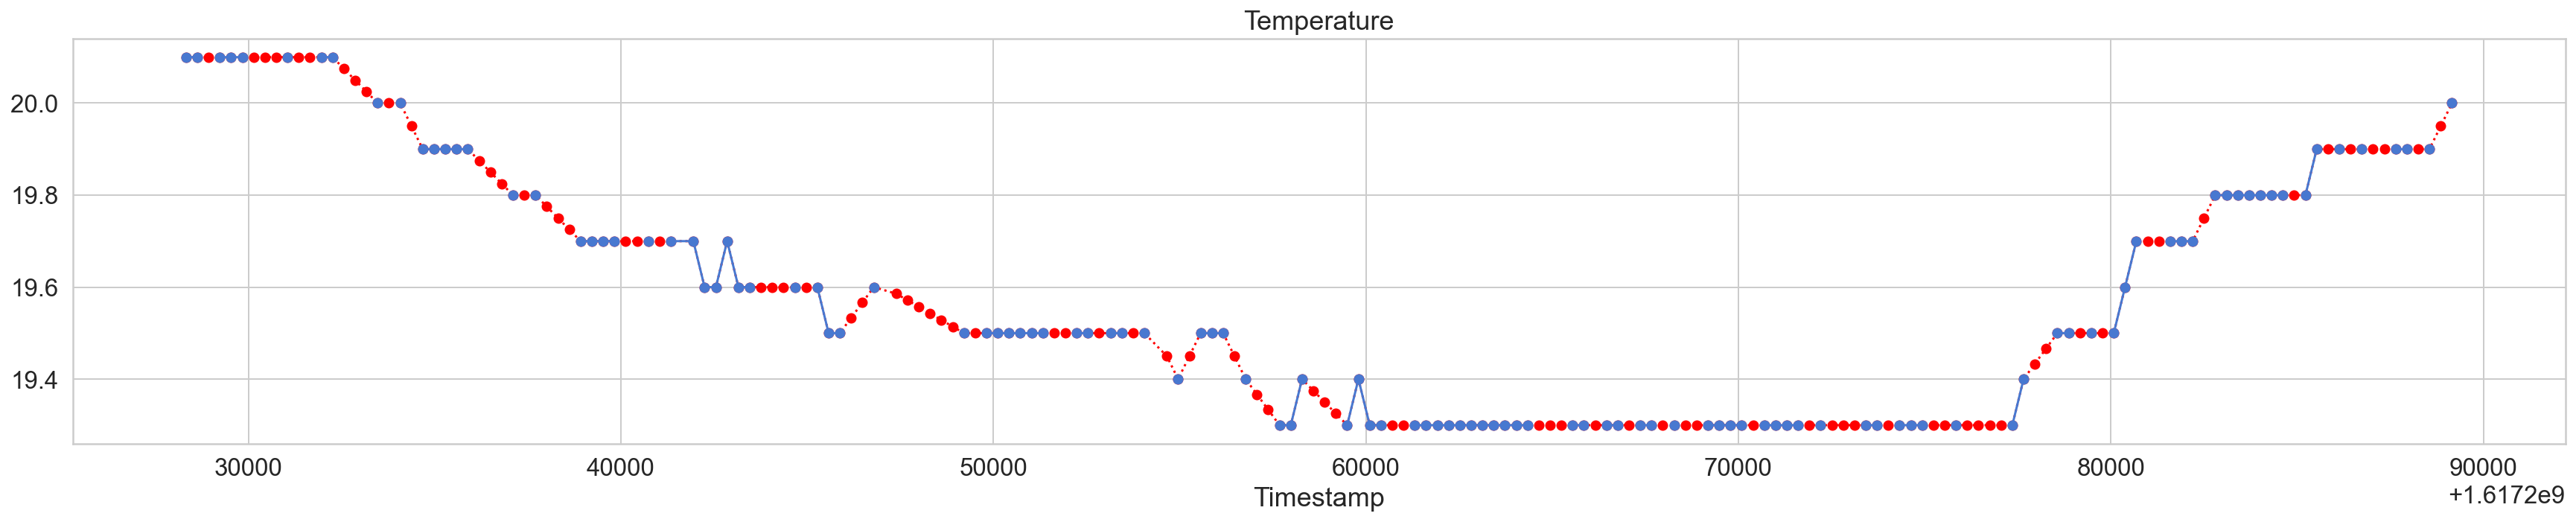

In [81]:
# Interpolate the NaNs by linear method

linear_imput=df.copy(deep=True)

linear_imput.interpolate(method='linear', inplace=True)

linear_imput[columnNam][a:a + taille].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

df[columnNam][a:a + taille].plot(title=columnNam, marker='o', figsize=(30, 5))

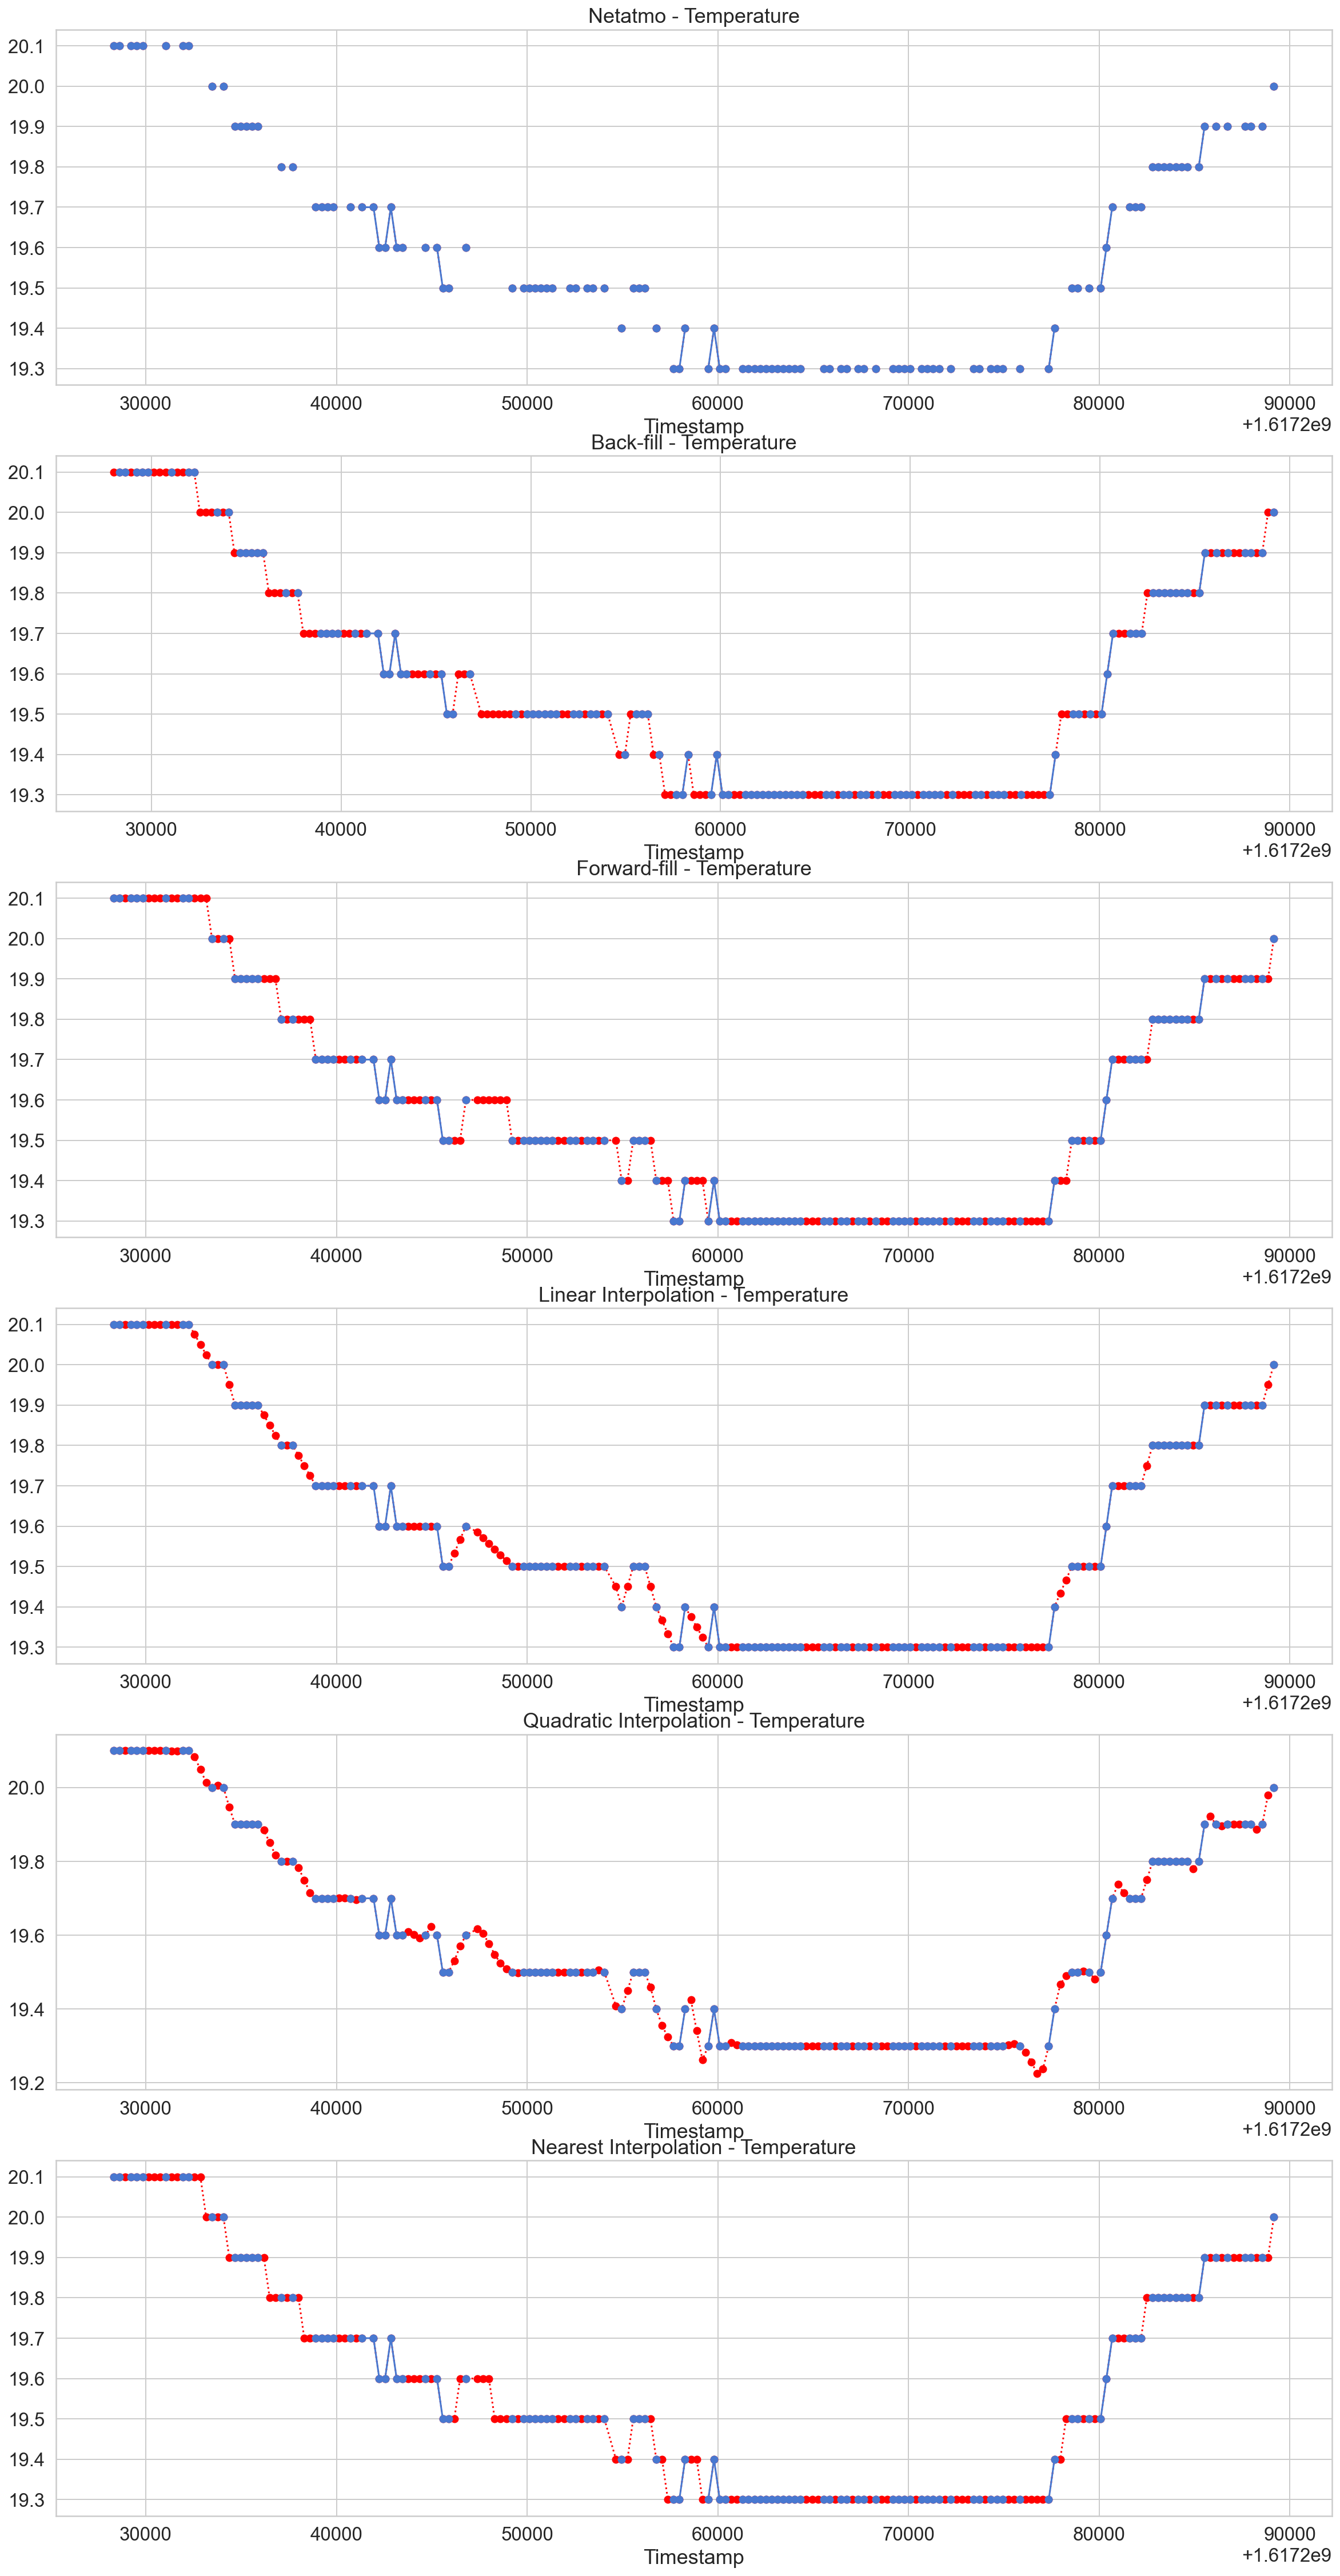

In [82]:
# Set nrows to 3 and ncols to 1
fig, axes = plt.subplots(6, 1, figsize=(20, 40))

# Create a dictionary of interpolations
interpolations = {'Netatmo': df, 'Back-fill':bfill_imputed, 'Forward-fill':ffill_imputed,
                  'Linear Interpolation': linear_imput, 'Quadratic Interpolation': quadratic_imput, 
                  'Nearest Interpolation': nearest_imput}

# Loop over axes and interpolations
for ax, df_key in zip(axes, interpolations):
  # Select and also set the title for a DataFrame
  interpolations[df_key][a:a + taille].Temperature.plot(color='red', marker='o', 
                                 linestyle='dotted', ax=ax)
  df[columnNam][a:a + taille].plot(title=df_key + ' - Temperature', marker='o', ax=ax)



  
plt.show()

In [ ]:
plt.data

In [75]:
import numpy as np
from sklearn.impute import KNNImputer
X1 = df.copy()
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(X1)

array([[  18.5       ,   58.        ,  803.        ,   35.        ,
        1017.20001221],
       [  20.10000038,   56.5       ,  689.        ,   36.        ,
        1017.25      ],
       [  20.10000038,   57.        ,  706.        ,   32.        ,
        1017.25      ],
       ...,
       [  15.8499999 ,   45.        ,  764.        ,   32.        ,
        1024.80004883],
       [  16.79999924,   52.        ,  743.        ,   34.        ,
        1024.69995117],
       [  16.79999924,   47.        ,  738.        ,   32.        ,
        1026.05001831]])

In [60]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94978 entries, 1617228022 to 1646088954
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  57121 non-null  float64
 1   Humidity     57020 non-null  float64
 2   CO2          56863 non-null  float64
 3   Noise        56835 non-null  float64
 4   Pressure     56894 non-null  float64
dtypes: float64(5)
memory usage: 4.3 MB


In [ ]:
X_imp=imputer.fit_transform(X1)

In [ ]:
X_imp

In [308]:
X_full.shape

(2064, 8)

In [ ]:
#visualize data 

# Import missingno as msno
import missingno as msno
import matplotlib.pyplot as plt

# Plot amount of missingness
msno.bar(dfX_fuul) # you can see pandas-profilin count part

plt.show()

In [309]:
dfX_fuul = pd.DataFrame(data=X_full,columns=["c1", "c2","c3", "c4","c5", "c6","c7", "c8"])

In [310]:
dfX_fuul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c1      2064 non-null   float64
 1   c2      2064 non-null   float64
 2   c3      2064 non-null   float64
 3   c4      2064 non-null   float64
 4   c5      2064 non-null   float64
 5   c6      2064 non-null   float64
 6   c7      2064 non-null   float64
 7   c8      2064 non-null   float64
dtypes: float64(8)
memory usage: 129.1 KB


array([[  20.2,   58. ,  704. ,   32. , 1017.2],
       [  20.1,   58. ,  689. ,   32. , 1017.3],
       [  20.1,   58. ,  706. ,   32. , 1017.3],
       ...,
       [  16.8,   52. ,  764. ,   32. , 1024.8],
       [  16.8,   52. ,  743. ,   32. , 1024.7],
       [  16.8,   52. ,  738. ,   32. , 1024.7]])

In [331]:
X.loc[columnNam]

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [332]:
columnNam

'Temperature'

In [339]:
X[:,0]

array([20.2, 20.1, 20.1, ..., 16.8, 16.8, 16.8])

In [354]:
df.Temperature

Timestamp
1617228022          NaN
1617228324    20.100000
1617228626    20.100000
1617228929    20.100000
1617229232          NaN
                ...    
1646087743    17.000000
1646088046    16.900000
1646088348          NaN
1646088651    16.799999
1646088954    16.799999
Name: Temperature, Length: 94978, dtype: float64

In [391]:
R_mcar

tensor([[1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0.],
        ...,
        [1., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0.]], dtype=torch.float64)

In [444]:
df.columns

Index(['Temperature', 'Humidity', 'CO2', 'Noise', 'Pressure'], dtype='object')

In [65]:
# mask pour évaluer les performances (mse,rmse, nrmse..)
m=R_mcar.numpy()
mk=m==1

maskPerf_Temperature = mk[:,0]
maskPerf_Humidity = mk[:,1]
maskPerf_CO2 = mk[:,2]
maskPerf_Noise = mk[:,3]
maskPerf_Pressure = mk[:,4]

In [95]:
df

Temperature  Humidity    CO2  Noise     Pressure
Timestamp                                                   
1617228022          NaN      58.0    NaN    NaN  1017.200012
1617228324    20.100000       NaN  689.0    NaN          NaN
1617228626    20.100000       NaN  706.0   32.0          NaN
1617228929          NaN      58.0    NaN   32.0  1017.200012
1617229232    20.100000      57.0  689.0    NaN  1017.200012
...                 ...       ...    ...    ...          ...
1646087743    17.000000       NaN    NaN   32.0          NaN
1646088046          NaN      52.0    NaN    NaN          NaN
1646088348          NaN       NaN  764.0    NaN  1024.800049
1646088651    16.799999      52.0  743.0    NaN  1024.699951
1646088954    16.799999       NaN  738.0    NaN          NaN

[94978 rows x 5 columns]

In [69]:
df.Temperature[maskPerf_Temperature]

Timestamp
1617228022   NaN
1617228929   NaN
1617230140   NaN
1617230443   NaN
1617230746   NaN
              ..
1646084414   NaN
1646086532   NaN
1646087441   NaN
1646088046   NaN
1646088348   NaN
Name: Temperature, Length: 37852, dtype: float64

In [70]:
data.Temperature[maskPerf_Temperature]

Timestamp
1617228022    20.2
1617228929    20.1
1617230140    20.1
1617230443    20.1
1617230746    20.1
              ... 
1646084414    16.9
1646086532    17.0
1646087441    17.0
1646088046    16.9
1646088348    16.8
Name: Temperature, Length: 37852, dtype: float64

In [74]:
from sklearn.metrics import mean_squared_error

y_true = X[maskmse][:,0]
y_pred =X_imp[maskmse][:,3]
mean_squared_error(y_true, y_pred)

NameError: name 'maskPerf_Temperaturee' is not defined

## Imputation des valeurs manquantes avec des variantes d’IterativeImputer
# https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Earl

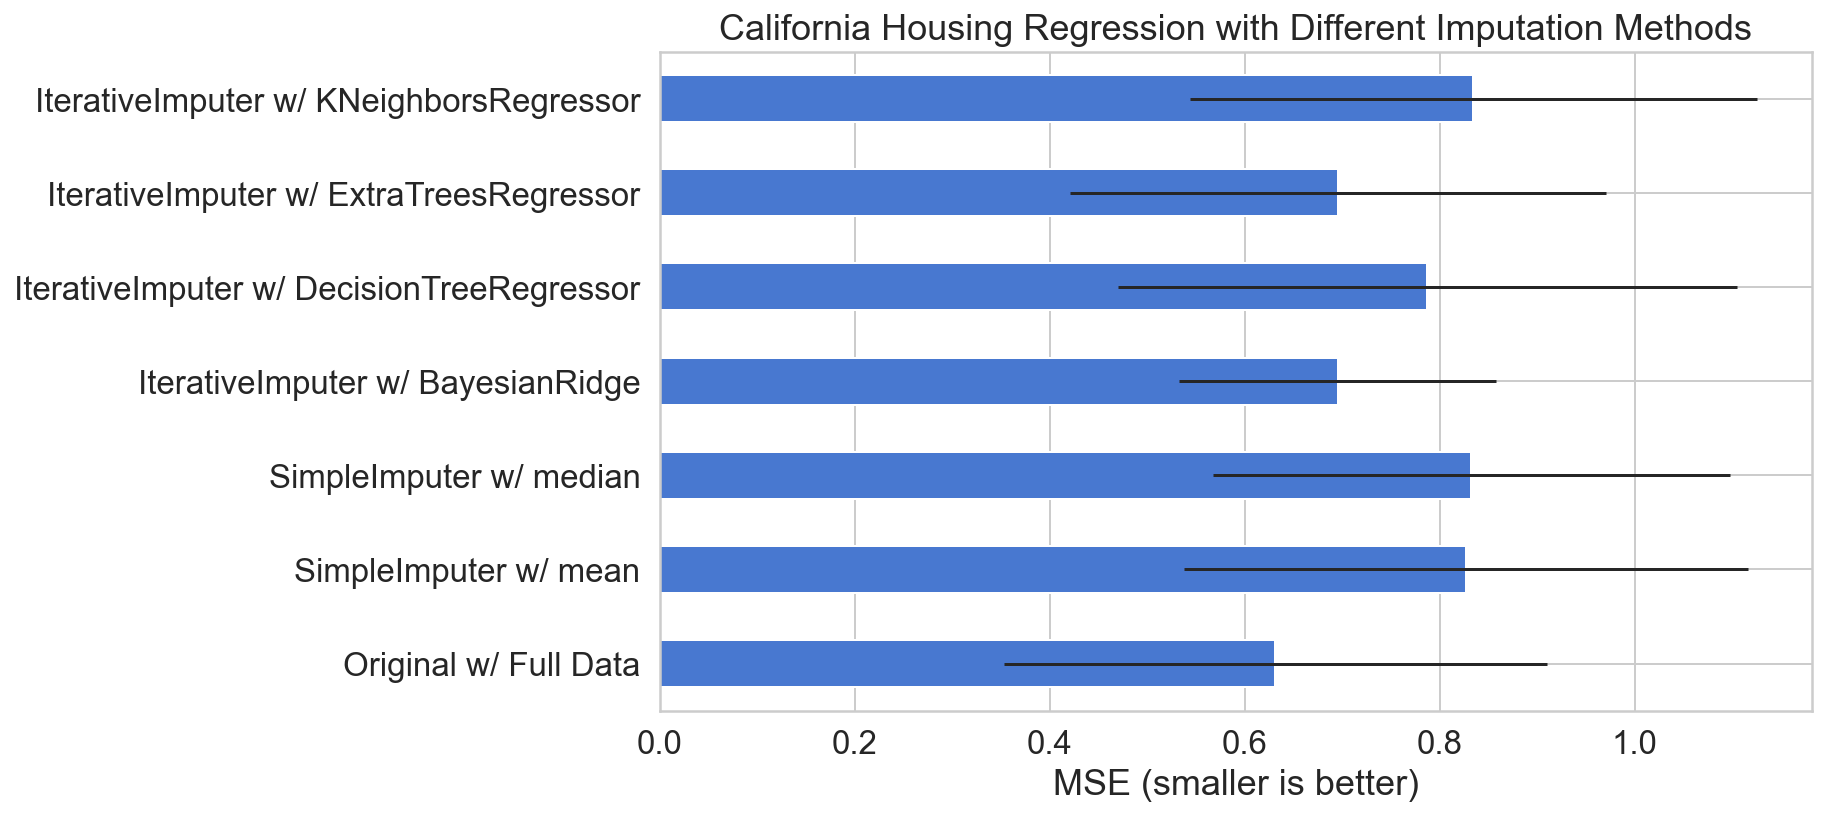

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features="sqrt", random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator), br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()